**1. Import needed libraries**



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")
#---------------------------------------
import kagglehub

print(tf.__version__)

2.19.0


**2. Preprocessing**

*2.1 Load dataset*

In [ ]:
# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

# Define the training and testing directories
train_dir = f"{dataset_path}/Training"
test_dir = f"{dataset_path}/Testing"

*2.2 Load data into DataFrames*

In [ ]:
# Function to create a DataFrame for the training data
def train_df(tr_path):
    # Get the class labels and their corresponding image paths
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    # Create a pandas DataFrame
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
# Function to create a DataFrame for the testing data
def test_df(ts_path):
    # Get the class labels and their corresponding image paths
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    # Create a pandas DataFrame
    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
# Create the training DataFrame
tr_df = train_df(train_dir)
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [ ]:
# Create the testing DataFrame
ts_df = test_df(test_dir)
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


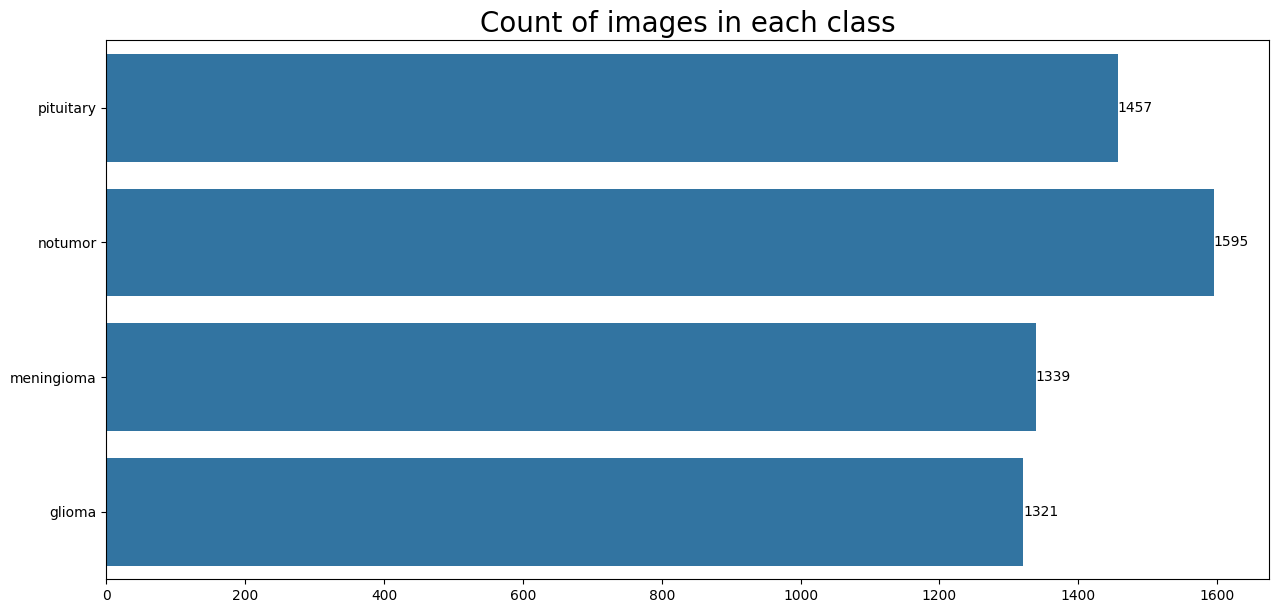

In [ ]:
# Visualize the distribution of classes in the training data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

# Set plot labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

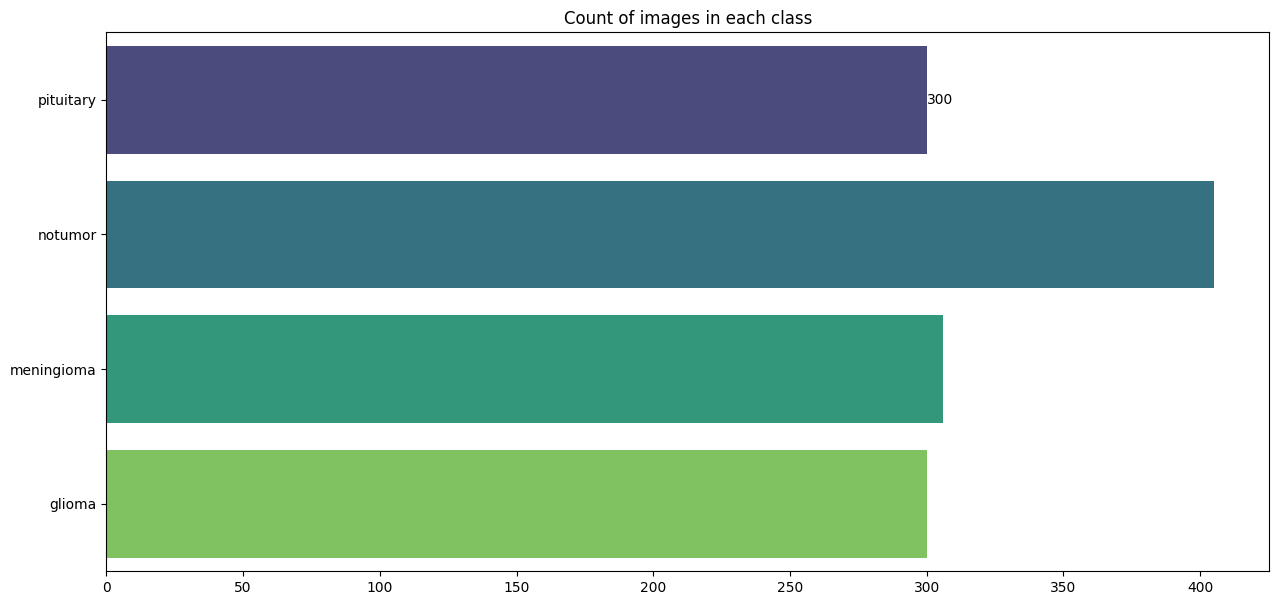

In [ ]:
# Visualize the distribution of classes in the testing data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

# Set plot labels and title
ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

*2.3 Split Data into Validation, and Test Sets*

In [ ]:
# Split the testing data into validation and testing sets
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])
valid_df

,Class Path,Class
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1070,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
554,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1284,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
899,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


*2.4 Data Preprocessing and Augmentation*

In [ ]:
# Define batch size and image size
batch_size = 32
img_size = (299, 299)

# Create an ImageDataGenerator for training and validation with data augmentation
_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

# Create an ImageDataGenerator for testing (only rescaling)
ts_gen = ImageDataGenerator(rescale=1/255)

# Create data generators for training, validation, and testing
tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


*2.5 Visualizing Sample Images*

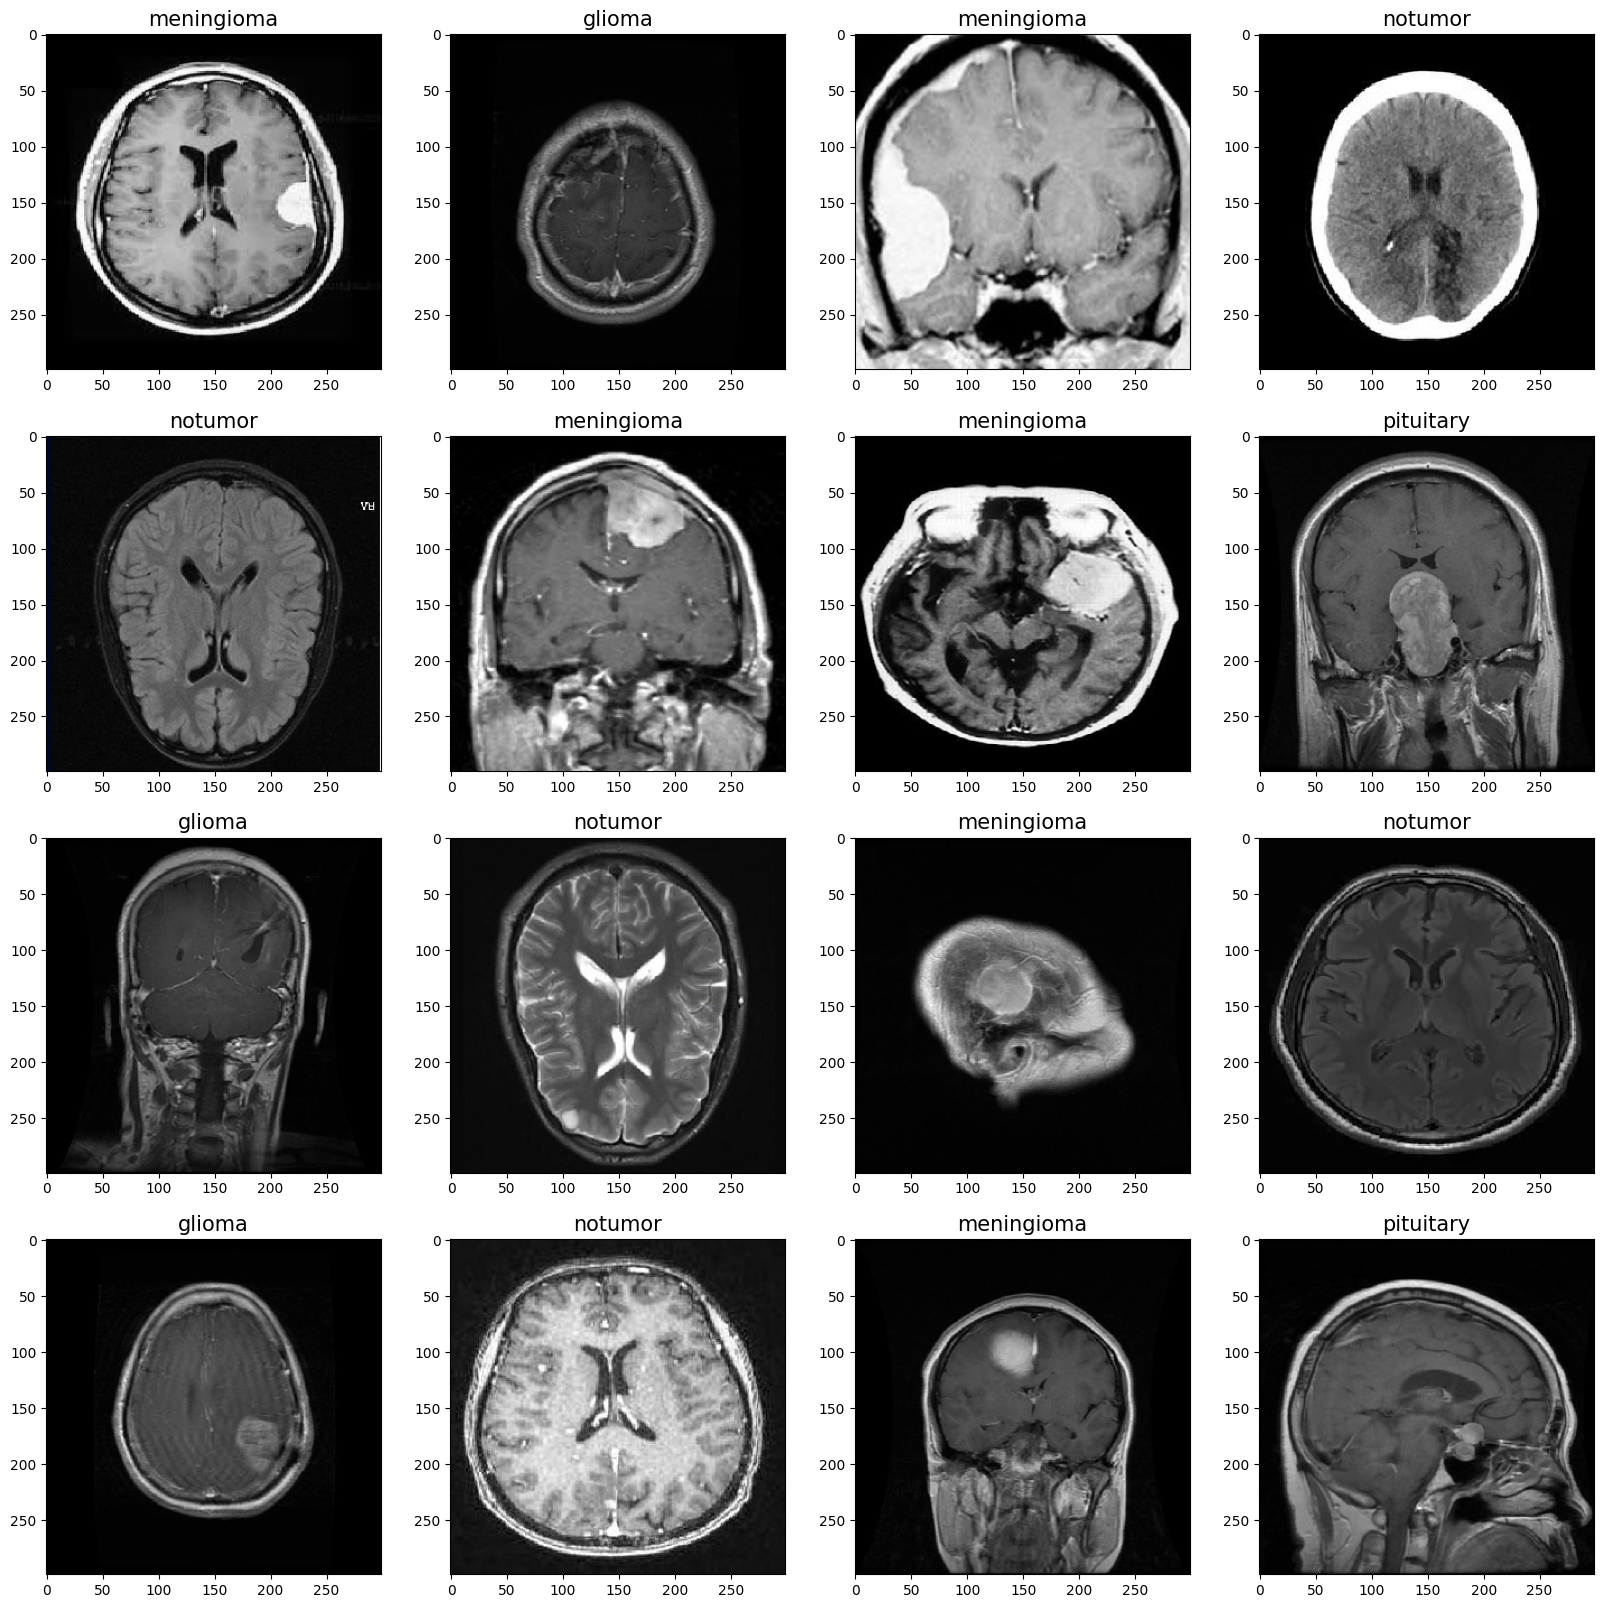

In [ ]:
# Get the class dictionary and a batch of images and labels from the test generator
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

# Create a figure to display the images
plt.figure(figsize=(20, 20))

# Loop through the images and labels and display them
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

**3. Model Building**

In [ ]:
# Build transfer learning model using Xception backbone

img_shape = (299, 299, 3)

# Load Xception base
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'  # This makes the output 1D (flattened)
)

# Optionally freeze base model
# for layer in base_model.layers:
#     layer.trainable = False

# Build final model
model = Sequential([
    base_model,
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')  # Adjust for number of classes
])

# Compile model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

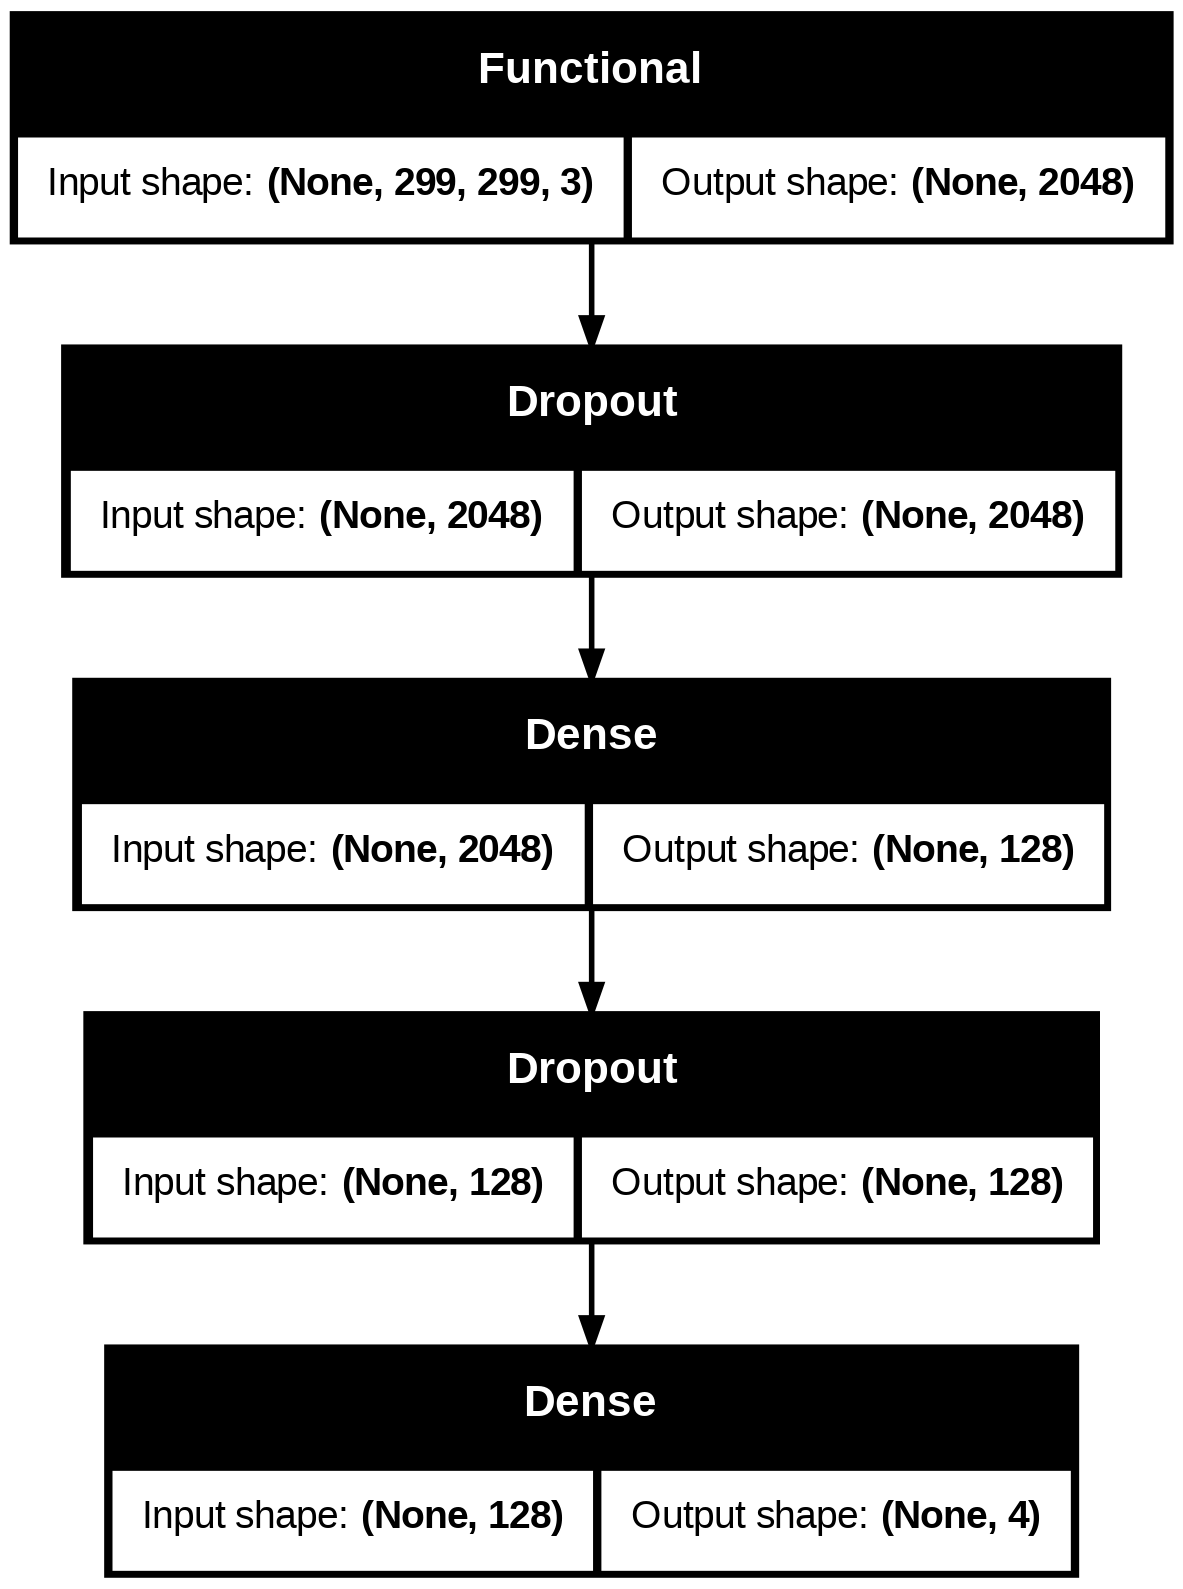

In [ ]:
# Display model architecture visually
tf.keras.utils.plot_model(model, show_shapes=True)

*3.1 Define Checkpoints*

In [ ]:
# Save best models (both .keras and .h5 formats)
checkpoint_keras = ModelCheckpoint(
    "best_model.keras",           # Saved in new recommended Keras format
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

# Callback to save best model as .h5 (legacy format)
checkpoint_h5 = ModelCheckpoint(
    "best_model.h5",              # Saved in legacy HDF5 format
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

**4. Training**

In [ ]:
# Train the model
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=[checkpoint_keras, checkpoint_h5])

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.7865 - loss: 0.6285 - precision: 0.8495 - recall: 0.6991
Epoch 1: val_accuracy improved from -inf to 0.93282, saving model to best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.93282, saving model to best_model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.7871 - loss: 0.6268 - precision: 0.8499 - recall: 0.6999 - val_accuracy: 0.9328 - val_loss: 0.2043 - val_precision: 0.9468 - val_recall: 0.9237
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9806 - loss: 0.0544 - precision: 0.9810 - recall: 0.9799
Epoch 2: val_accuracy did not improve from 0.93282

Epoch 2: val_accuracy did not improve from 0.93282
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 811ms/step - accuracy: 0.9806 - loss: 0.0544 - precision: 0.9810 - recall: 0.9799 - val_accuracy: 0.9206 - val_loss: 0.2320 - val_precision: 0.9287 - val_recall: 0.9145
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9918 - loss: 0.0337 - precision: 0.9920 - recall: 0.9900
Epoch 3: val_accuracy improved from 0.93282 to 0.98626, saving model to best_model.keras

Epoch 3: val_accuracy improved from 0.93282 to 0.98626, saving model to best_model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 838ms/step - accuracy: 0.9918 - loss: 0.0337 - precision: 0.9920 - recall: 0.9900 - val_accuracy: 0.9863 - val_loss: 0.0461 - val_precision: 0.9893 - val_recall: 0.9847
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9919 - loss: 0.0245 - precision: 0.9923 - recall: 0.9910
Epoch 4: val_accuracy improved from 0.98626 to 0.99237, saving model to best_model.keras

Epoch 4: val_accuracy improved from 0.98626 to 0.99237, saving model to best_model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 845ms/step - accuracy: 0.9919 - loss: 0.0245 - precision: 0.9923 - recall: 0.9911 - val_accuracy: 0.9924 - val_loss: 0.0249 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9975 - loss: 0.0073 - precision: 0.9976 - recall: 0.9971
Epoch 5: val_accuracy did not improve from 0.99237

Epoch 5: val_accuracy did not improve from 0.99237
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 841ms/step - accuracy: 0.9975 - loss: 0.0073 - precision: 0.9976 - recall: 0.9971 - val_accuracy: 0.9908 - val_loss: 0.0416 - val_precision: 0.9908 - val_recall: 0.9908
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9969 - loss: 0.0139 - precision: 0.9971 - recall: 0.9969
Epoch 6: val_accuracy did not improve from 0.99237

Epoch 6: val_accuracy did not improve from 0.99237
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 838ms/step - accuracy: 0.9969 - loss: 0.0139 - precision: 0.9971 - recall: 0.9969 - val_accuracy: 0.9893

179/179 ━━━━━━━━━━━━━━━━━━━━ 210s 886ms/step - accuracy: 0.9969 - loss: 0.0127 - precision: 0.9969 - recall: 0.9969 - val_accuracy: 0.9969 - val_loss: 0.0081 - val_precision: 0.9969 - val_recall: 0.9969
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9984 - loss: 0.0047 - precision: 0.9984 - recall: 0.9984
Epoch 8: val_accuracy did not improve from 0.99695

Epoch 8: val_accuracy did not improve from 0.99695
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 843ms/step - accuracy: 0.9983 - loss: 0.0048 - precision: 0.9983 - recall: 0.9983 - val_accuracy: 0.9771 - val_loss: 0.0933 - val_precision: 0.9771 - val_recall: 0.9771
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9986 - loss: 0.0075 - precision: 0.9986 - recall: 0.9985
Epoch 9: val_accuracy did not improve from 0.99695

Epoch 9: val_accuracy did not improve from 0.99695
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 839ms/step - accuracy: 0.9986 - loss: 0.0075 - precision: 0.9986 - recall: 0.9984 - val_accuracy: 0.9969

In [16]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

*4.1 Visualize model performance*

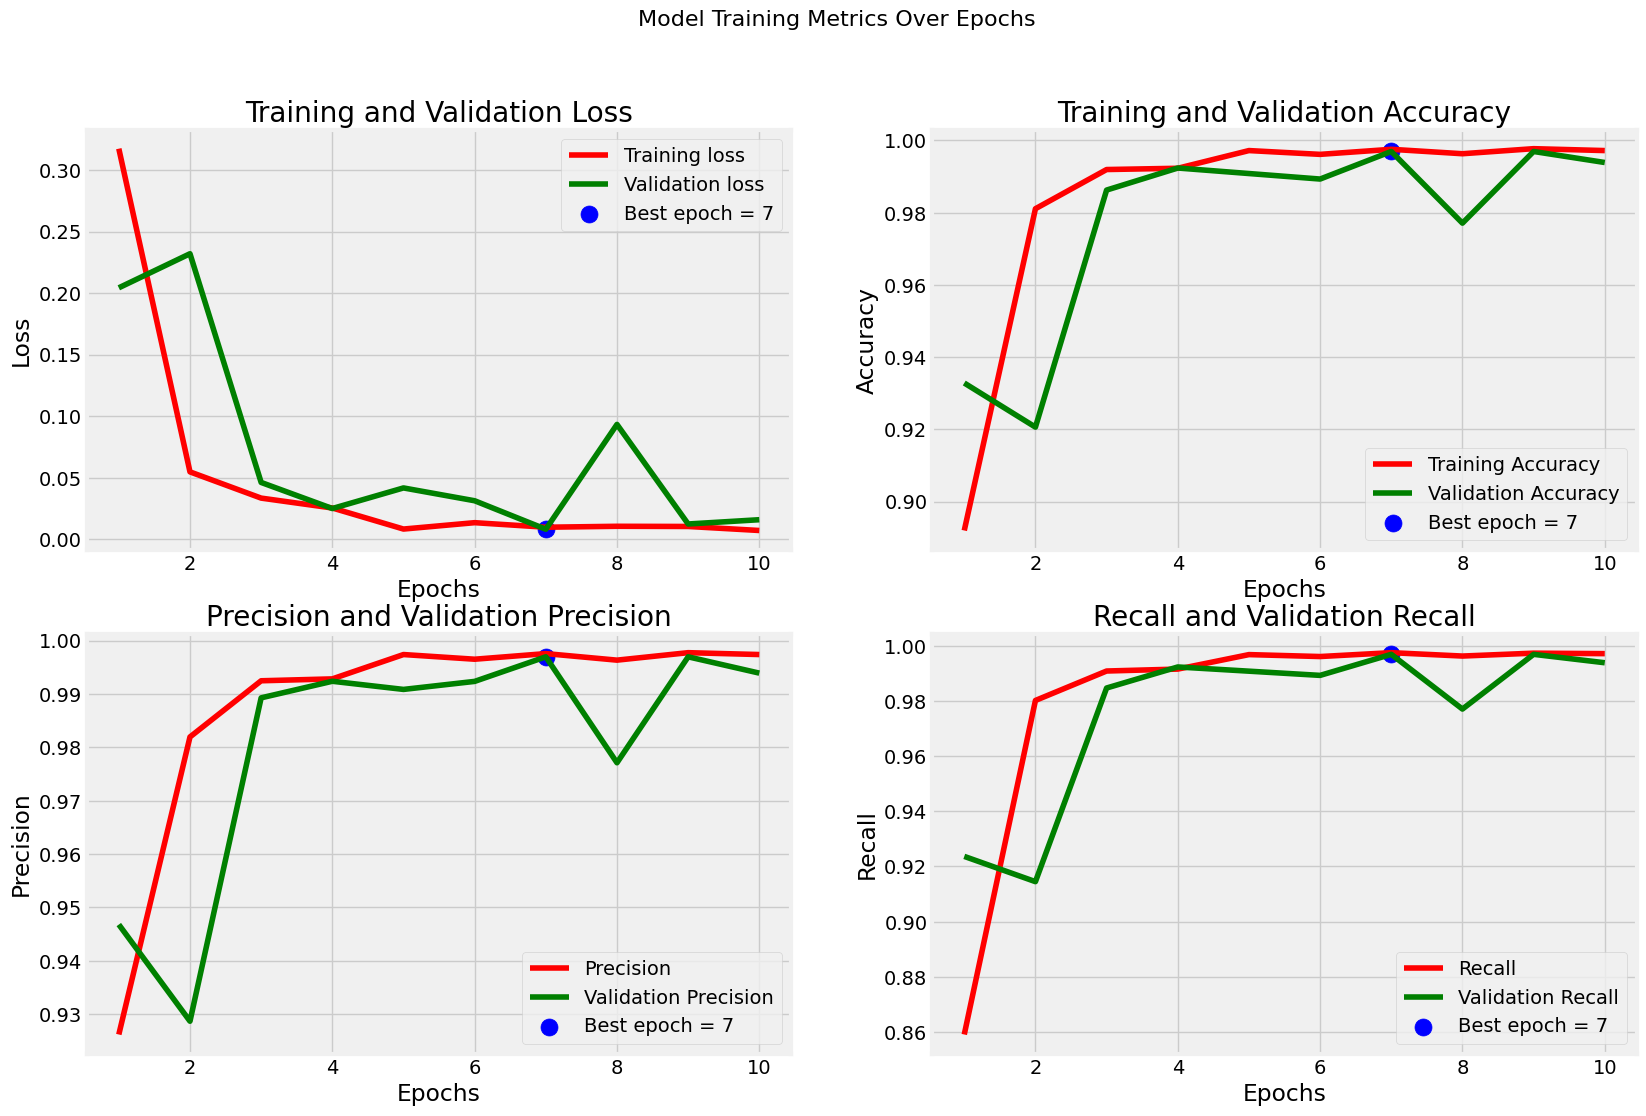

In [ ]:
# Extract metrics from training history
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

# Find best epochs for accuracy and lowest loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Plot training & validation accuracy and loss
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

# Loss
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

**5. Evaluation**

In [26]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.9999 - loss: 5.6609e-04 - precision: 0.9999 - recall: 0.9999
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.9966 - loss: 0.0072 - precision: 0.9966 - recall: 0.9966
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9904 - loss: 0.0333 - precision: 0.9904 - recall: 0.9904
Train Loss: 0.0007
Train Accuracy: 99.98%
--------------------
Validation Loss: 0.0116
Validation Accuracy: 99.54%
--------------------
Test Loss: 0.0643
Test Accuracy: 98.78%


In [ ]:
# Predict probabilities
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step


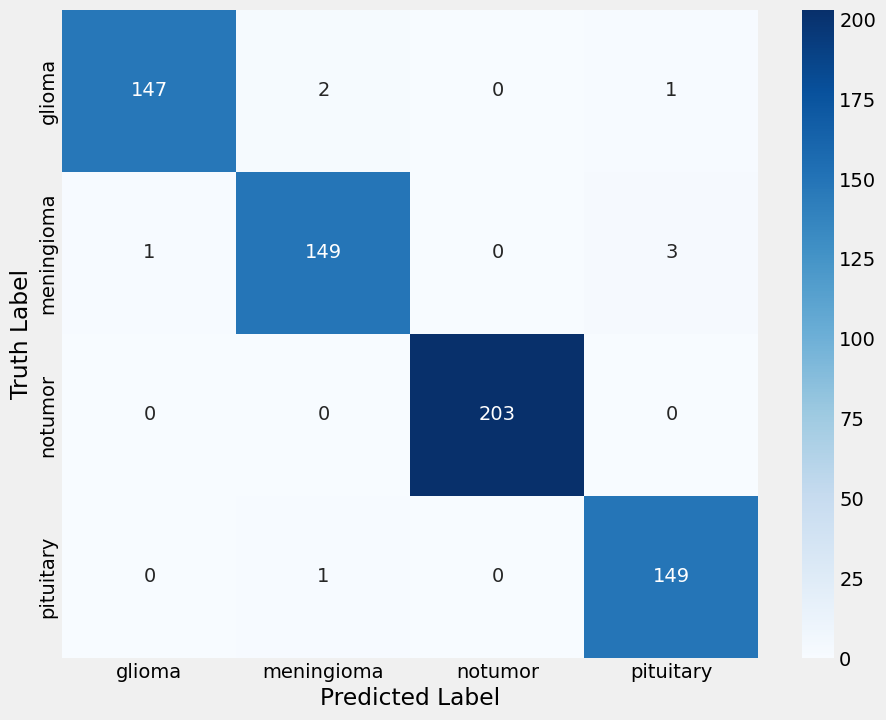

In [ ]:
# Generate and plot confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [29]:
class_names = list(ts_gen.class_indices.keys())
clr = classification_report(ts_gen.classes, y_pred, target_names=class_names)
print(clr)

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       150
  meningioma       0.98      0.97      0.98       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.97      0.99      0.98       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



**6. Visualize Sample Predictions**

In [31]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


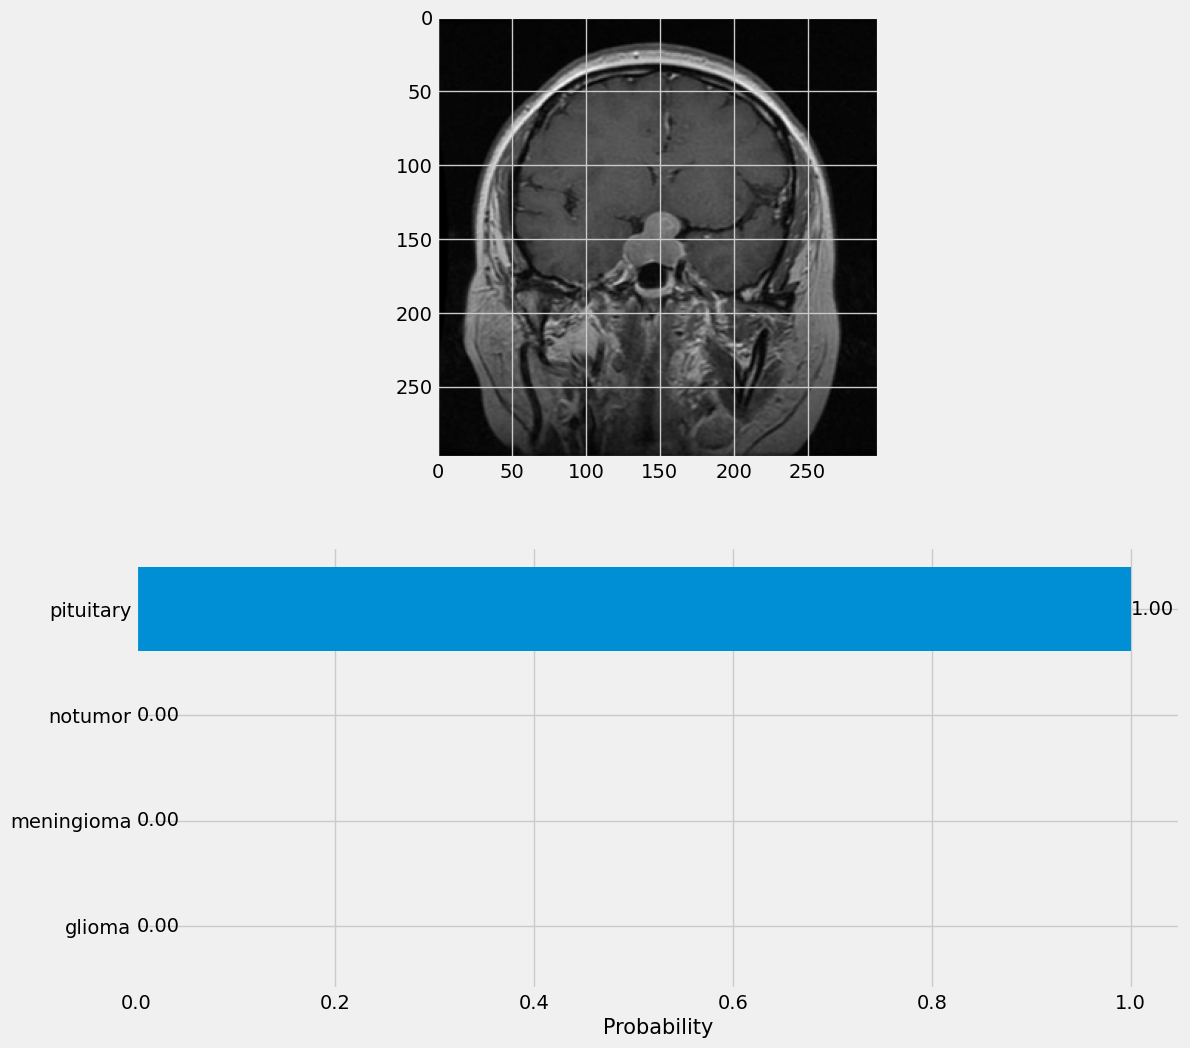

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


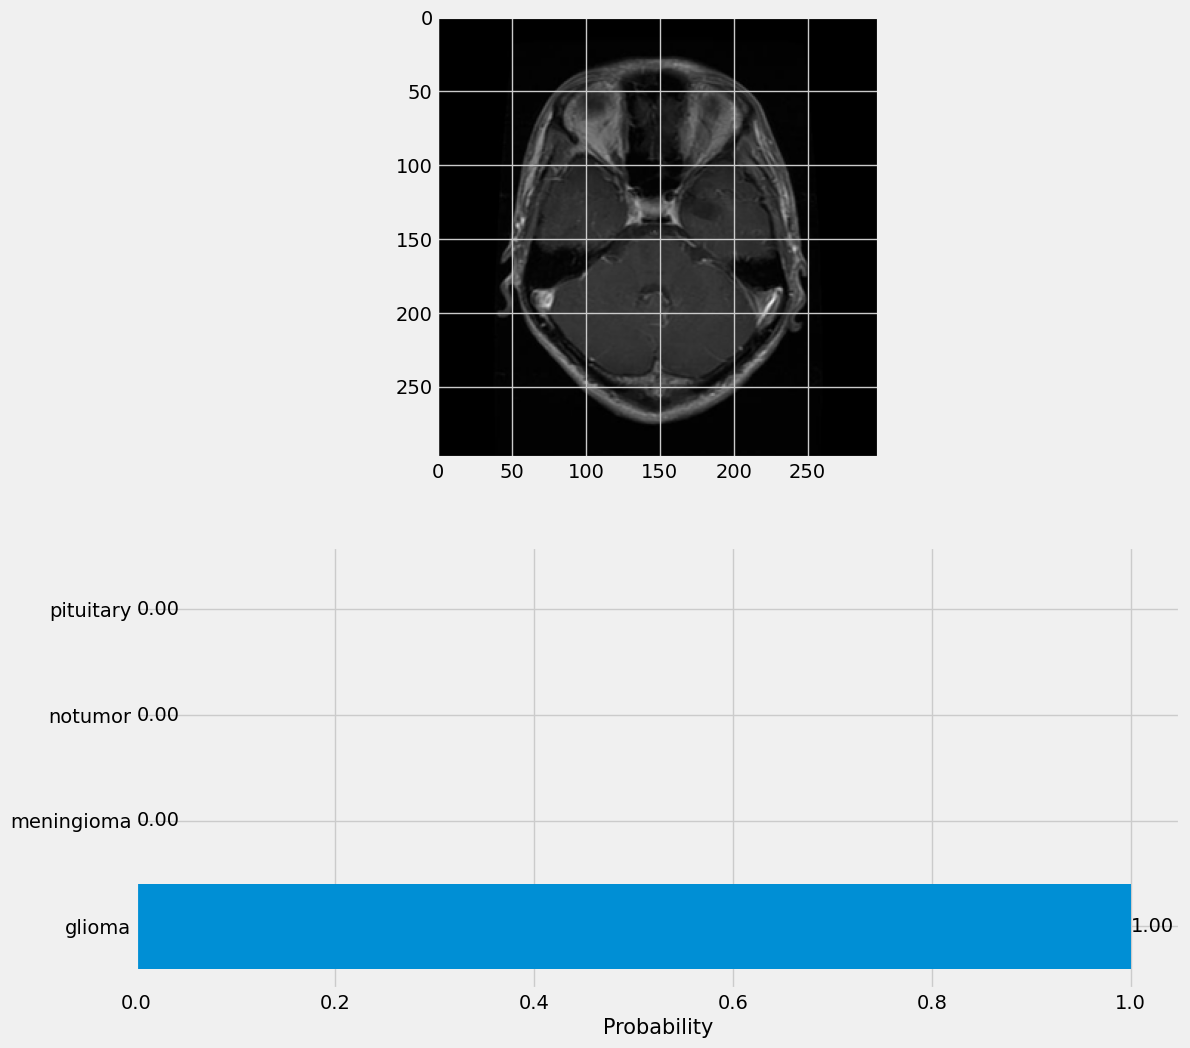

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


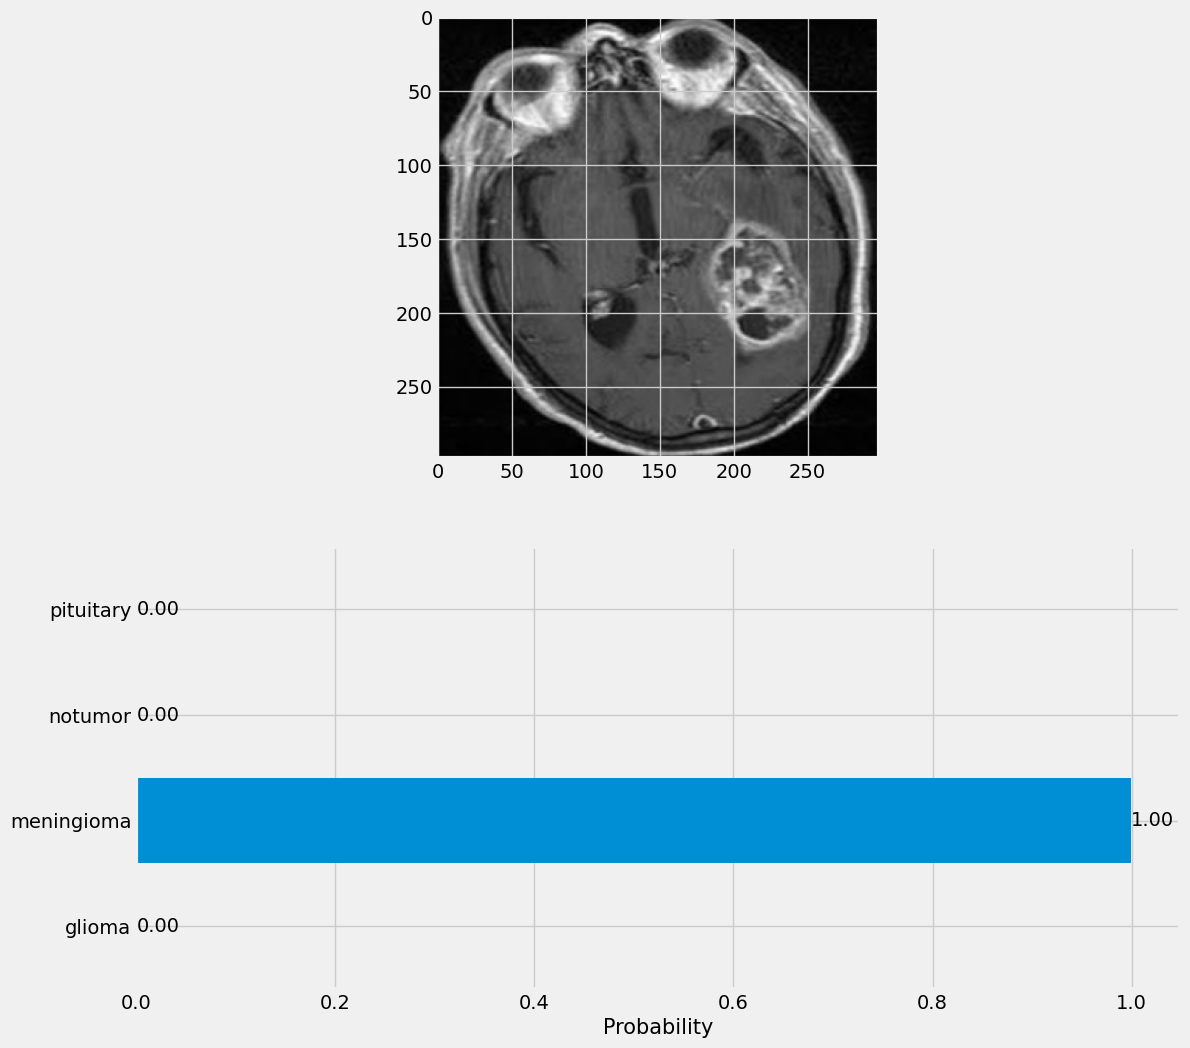

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


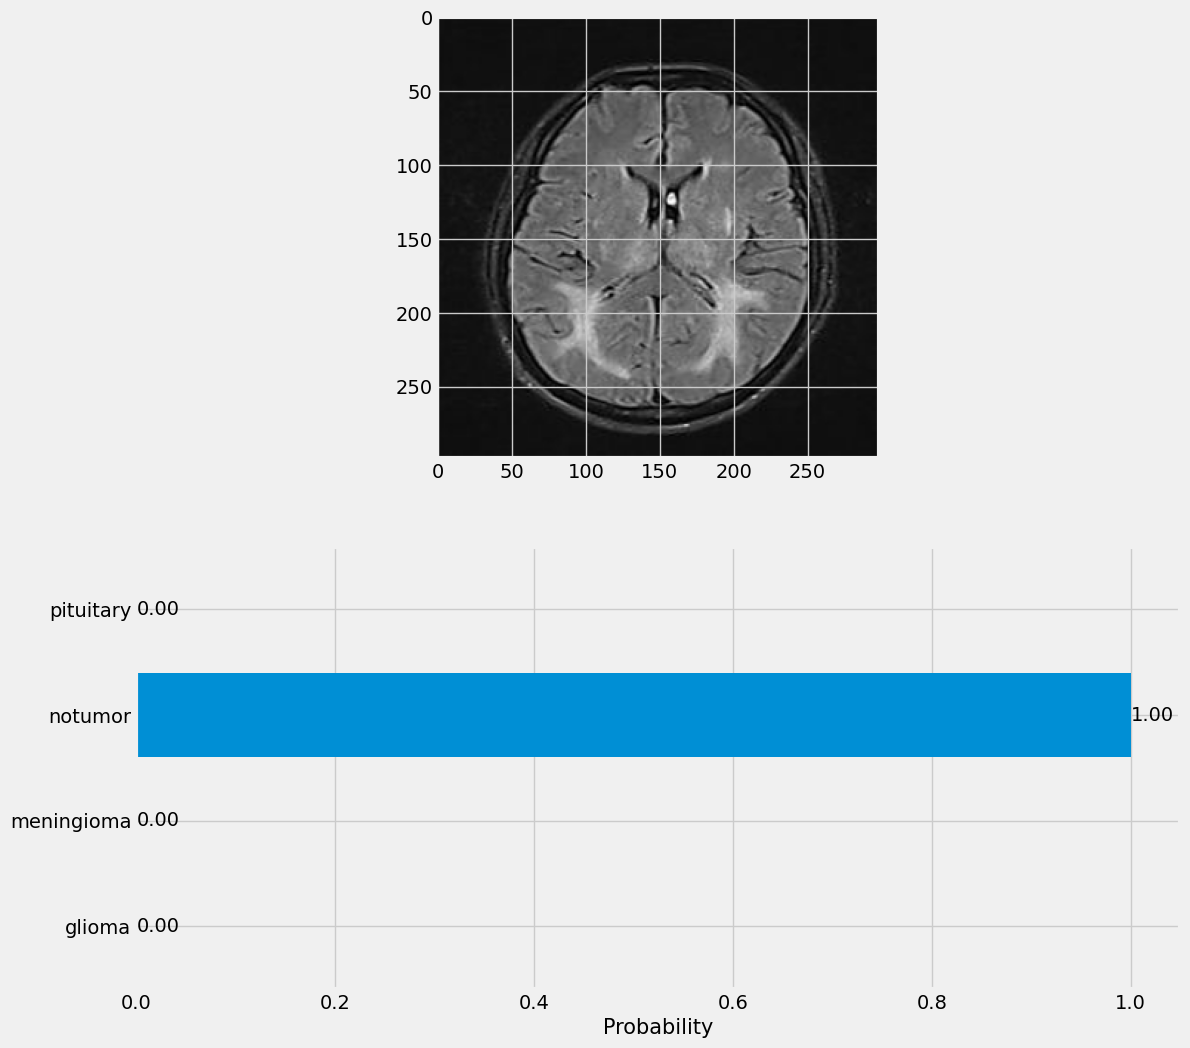

In [32]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0001.jpg')
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0001.jpg')
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

**7. Save and Export Model**

In [ ]:
from google.colab import files

# Download the Keras model
files.download('best_model.keras')

# Download the HDF5 model
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>